In [1]:
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import LineString, Point

In [2]:
jaipur_region = gpd.read_file("data/jaipur_district_adm2.geojson", driver="geojson")  
jaipur_region.to_crs(epsg=4326, inplace=True) 
jaipur_boundary = jaipur_region.geometry.values[0].exterior.coords[:]
polygon_string = " ".join([f"{lat} {lon}" for lon, lat in jaipur_boundary])
polygon_string # polygon string as boundary for overpass query

'26.469111999359935 75.14878800267167 26.473824999360954 75.14514200267155 26.479772999362478 75.14702600267236 26.482100567363194 75.14895017167291 26.48571599936413 75.15193900267366 26.49019999936526 75.15282400267418 26.493577098366128 75.15285546167458 26.500075999367684 75.1529160026751 26.503947999368208 75.1408460026736 26.51296001937008 75.12935199767267 26.52347899937215 75.11593600267149 26.52734217037323 75.1184264256723 26.533277999374796 75.12225300267335 26.54016099937655 75.12385600267422 26.541997598377066 75.12377329067441 26.546777999378182 75.12355800267476 26.55174999937912 75.11476900267381 26.555884999379778 75.10433200267255 26.55497199937935 75.09799200267149 26.548490999377176 75.08177200266833 26.542954999375677 75.07734700266714 26.543437635375764 75.07443483966678 26.54395899937574 75.07128900266625 26.553905219378 75.06367464766596 26.555837999378394 75.06219500266583 26.565196999380838 75.06604000266728 26.573308999382903 75.06768000266824 26.582211999385

In [3]:
# Build the Overpass  query
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
  // Get bus, train, and metro routes
  relation["route"~"bus|trolleybus|train|light_rail|tram|subway|metro|rail"](poly:"{polygon_string}");
  way["railway"](poly:"{polygon_string}");

);
out body;
>;
out skel qt;
"""

# Make the API call
response = requests.post(overpass_url, data={'data': overpass_query}) # Send the POST request
data = response.json() # Parse response as JSON

ROUTE

In [4]:
bus_route_types = ['bus', 'trolleybus']
rail_route_types = ['train','rail']
subway_route_types = ['subway', 'metro','tram','light_rail']

relations_bus = []
relations_train = []
relations_subway = []
for el in data['elements']:
  if 'tags' not in el:
    continue
  if el['type'] == 'relation':
    if el['tags'].get('route') in rail_route_types:
      relations_train.append(el)
    elif el['tags'].get('route') in subway_route_types:
      relations_subway.append(el)
    elif el['tags'].get('route') in bus_route_types:
      relations_bus.append(el)
print(f"Found {len(relations_train)} train routes, {len(relations_subway)} subway routes, and {len(relations_bus)} bus routes.")

Found 6 train routes, 2 subway routes, and 38 bus routes.


In [5]:
# Print details about the first route
modes = [relations_bus, relations_train, relations_subway]
for mode in modes:
    if mode:
        first_route = mode[0]
        tags = first_route.get('tags', {})
        print(f"First route of {first_route['tags'].get('route')}:")
        print(f"  Name: {first_route['tags'].get('name', 'N/A')}")
        print(f"  Ref: {first_route['tags'].get('ref', 'N/A')}")
        print(f"  Operator: {first_route['tags'].get('operator', 'N/A')}")
        print(list(tags.keys()))

First route of bus:
  Name: Bus 7: Khirni Fatak - Transport Nagar
  Ref: 7
  Operator: JCTSL
['from', 'interval', 'name', 'opening_hours', 'operator', 'public_transport', 'ref', 'roundtrip', 'route', 'to', 'type']
First route of train:
  Name: Double Decker Express 12985: Jaipur → Delhi Sarai Rohilla
  Ref: 12985
  Operator: North Western Railway
['check_date', 'duration', 'from', 'name', 'network', 'operator', 'passenger', 'public_transport:version', 'ref', 'route', 'sleeping_car', 'to', 'type']
First route of subway:
  Name: Pink Line (Mansarovar --> Badi Chaupar)
  Ref: Pink Line
  Operator: JMRC
['colour', 'duration', 'from', 'interval', 'interval:conditional', 'name', 'name:hi', 'network', 'network:wikidata', 'opening_hours', 'operator', 'public_transport:version', 'ref', 'route', 'to', 'type', 'wikidata', 'wikipedia']


In [6]:
def get_gdfroute_from_rel(relation):
    """
    Convert an Overpass relation to a GeoDataFrame.
    """
    route_geoms = []
    route_labels = []
    route_from = []
    route_to = []
    route_network = []
    route_operator = []
    route_interval = []
    
    nodes = {el['id']: el for el in data['elements'] if el['type'] == 'node'}
    ways = {el['id']: el for el in data['elements'] if el['type'] == 'way'}

    for rel in relation:
        # Get route number (ref) or fall back to 'name'
      ref = rel.get('tags', {}).get('ref') or rel.get('tags', {}).get('name') or f"relation {rel['id']}"
      operator = rel.get('tags', {}).get('operator')
      interval = rel.get('tags', {}).get('interval')
      from_ = rel.get('tags', {}).get('from')
      to_ = rel.get('tags', {}).get('to')
      network = rel.get('tags', {}).get('network')

      # Find member ways
      member_way_ids = [m['ref'] for m in rel['members'] if m['type'] == 'way']
      coords = []
      for wid in member_way_ids:
          way = ways.get(wid)
          if not way:
              continue
          line_coords = []
          for nid in way['nodes']:
              node = nodes.get(nid)
              if node:
                  line_coords.append((node['lon'], node['lat']))
          if len(line_coords) > 1:
              coords.append(LineString(line_coords))
      
      if coords:
          # Combine into MultiLine if more than one segment, else just use the LineString
          geom = coords[0] if len(coords) == 1 else gpd.GeoSeries(coords).unary_union
          route_geoms.append(geom)
          route_labels.append(ref)
          route_operator.append(operator)
          route_interval.append(interval)
          route_from.append(from_)
          route_to.append(to_)
          route_network.append(network)

        
    gdf = gpd.GeoDataFrame({
        'route': route_labels,
        'operator': route_operator,
        'interval': route_interval,
        'geometry': route_geoms,
        'from': route_from,
        'to': route_to,
        'network': route_network,

    }, crs="EPSG:4326")
    
    return gdf

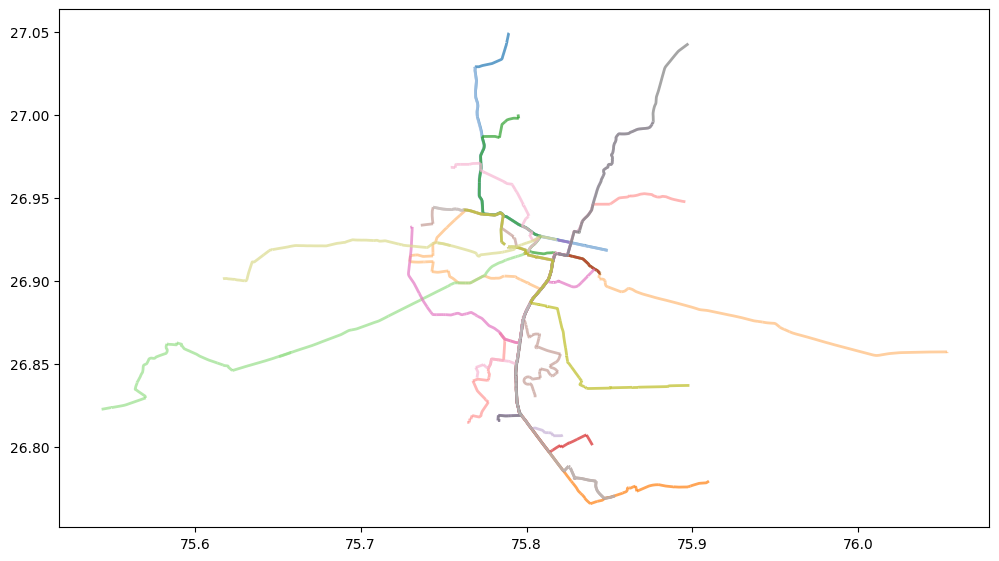

In [ ]:
gdf_bus = get_gdfroute_from_rel(relations_bus)
# filter long distance bus and dedupe
gdf_bus = gdf_bus[gdf_bus['route']!= 'Jaipur To Bharatpur (RSRTC Express)']
gdf_bus = gdf_bus.groupby('route').first().reset_index()  # dedupe by route
# get color
route_to_idx = {route: i for i, route in enumerate(gdf_bus['route'].unique())}
cmap = plt.get_cmap('tab20')
gdf_bus['color'] = gdf_bus['route'].map(lambda route: mcolors.to_hex(cmap(route_to_idx[route])))
# gdf_bus.head()

fig, ax = plt.subplots(figsize=(12, 12))
gdf_bus.plot(ax=ax, color=gdf_bus['color'], linewidth=2, label='Bus', alpha=0.7)
plt.show()

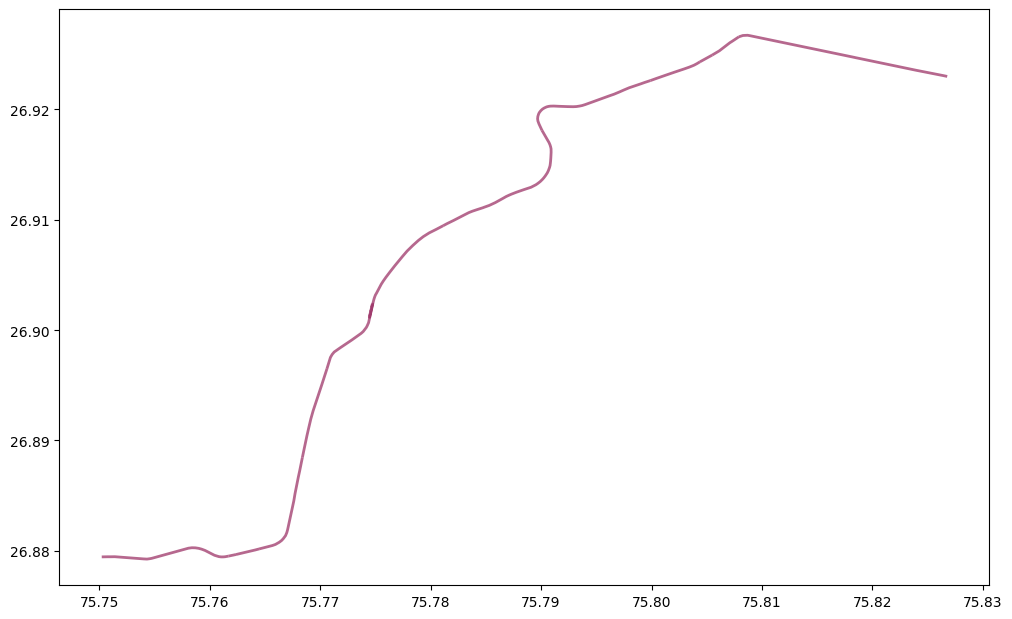

In [ ]:
gdf_metro = get_gdfroute_from_rel(relations_subway)
gdf_metro['color'] = "#ab748f"  # Pink color for subway
gdf_metro = gdf_metro.groupby('route').first().reset_index() # dedupe by route
# gdf_metro.head()

fig, ax = plt.subplots(figsize=(12, 12))
gdf_metro.plot(ax=ax, color=gdf_metro['color'], linewidth=2, label='Train', alpha=0.7)
plt.show()

In [27]:
way_train = []
for el in data['elements']:
  if 'tags' not in el:
    continue
  if el['type'] == 'way':
    if el['tags'].get('railway') in rail_route_types:
      way_train.append(el)
  
# Convert way data to GeoDataFrame of linestrings
def get_gdfway_from_way(ways):
    """
    Convert a list of way elements to a GeoDataFrame.
    """
    route_geoms = []
    route_gauge  = []
    route_service = []
    route_voltage = []

    for way in ways:
        # Get route number (ref) or fall back to 'name'
        ref = way.get('tags', {}).get('ref') or way.get('tags', {}).get('name') or f"way {way['id']}"
        gauge = way.get('tags', {}).get('gauge')
        service = way.get('tags', {}).get('service')
        voltage = way.get('tags', {}).get('voltage')

        coords = []
        for nid in way['nodes']:
            node = next((el for el in data['elements'] if el['type'] == 'node' and el['id'] == nid), None)
            if node:
                coords.append((node['lon'], node['lat']))
        
        if len(coords) > 1:
            geom = LineString(coords)
            route_geoms.append(geom)
            route_gauge.append(gauge)
            route_service.append(service)
            route_voltage.append(voltage)
            
    gdf = gpd.GeoDataFrame({
        'route': [f"way {i}" for i in range(len(route_geoms))],
        'gauge': route_gauge,
        'service': route_service,
        'voltage': route_voltage,
        'geometry': route_geoms
    }, crs="EPSG:4326")
    return gdf

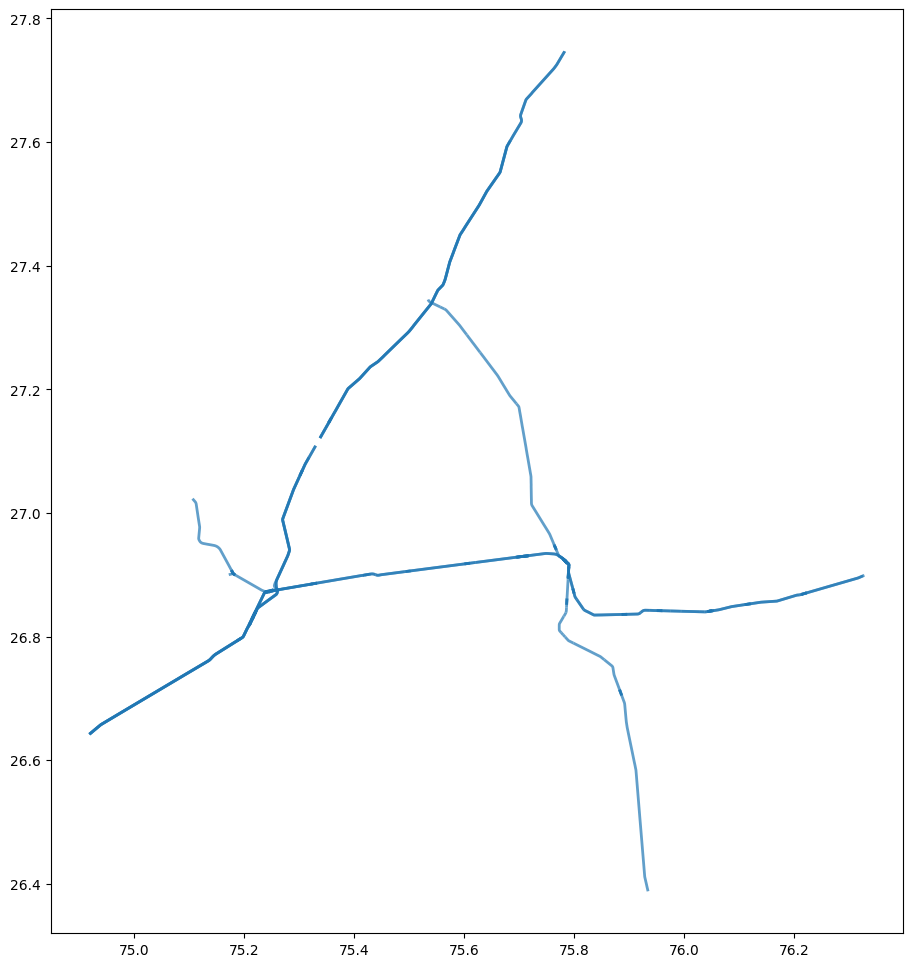

In [ ]:
gdf_train = get_gdfway_from_way(way_train)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_train.plot(ax=ax, linewidth=2, label='Train', alpha=0.7)
plt.show()

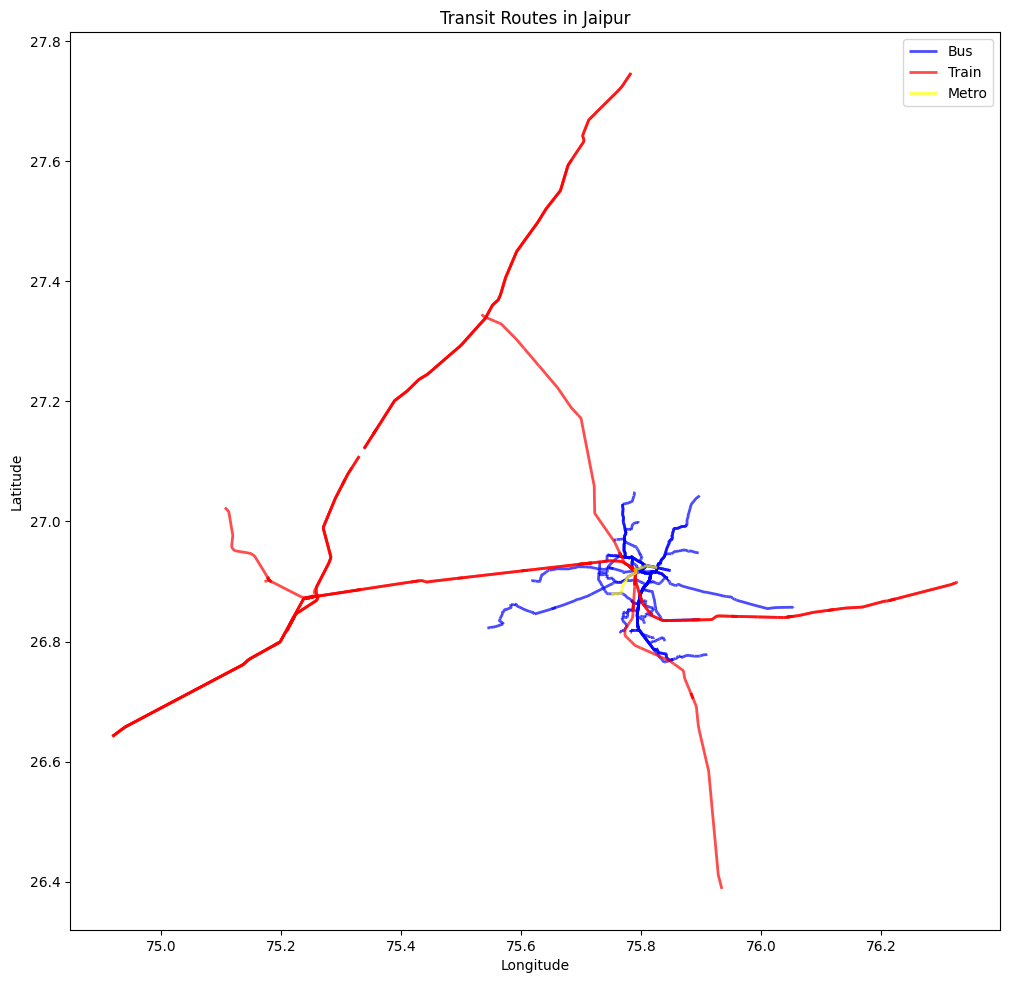

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_bus.plot(ax=ax, color='blue', linewidth=2, label='Bus', alpha=0.7)
gdf_train.plot(ax=ax, color='red', linewidth=2, label='Train', alpha=0.7)
gdf_metro.plot(ax=ax, color='yellow', linewidth=2, label='Metro', alpha=0.7)
ax.set_title("Transit Routes in Jaipur")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [33]:
# COnvert to Geojson
gdf_bus.to_file("../../public/data/mapMain/bus_routes.geojson", driver='GeoJSON')
gdf_train.to_file("../../public/data/mapMain/train_routes.geojson", driver='GeoJSON')
gdf_metro.to_file("../../public/data/mapMain/metro_routes.geojson", driver='GeoJSON')